# Llama DAI Research - Part 1

Objective of the analysis: understand where DAI is located

Data extraction and Data wrangling, to prepare it for anaylsis. Apply Data Management skills in order to get a consolidated table with information about DAI in circulation and where it is located.

Table will contain:
- Historical TVL information from protocols in DefiLlama
- Historical DAI circulating information from DefiLlama
- Snapshot at the moment the notebook is executed with DAI in known addresses

### 1. Data Extraction & Inspection
Sources used:
1. all.csv - downloaded from DefiLlama
2. chain-dataset-All.csv - downloaded from DefiLlama
3. dai circulating amounts from `research_utils.py` (updated: whenever notebook is run)
4. ethereum_tags.csv - user-built with addresses and tags from etherscan mainly

Check what are the data fields and what does each represent
Double check metrics with chain-dataset_All.csv from Defillama's frontend

### 2. Data Wrangling
Transforming data in order to consolidate it into one table - data obtained from different sources
Schema for the table explained in [Data Transformation](#2.-Data-Transformation)

### Output
1. dai_holdings.csv - contains x DAI top holders fetched through transpose API
2. dai_locs.csv - contains a table with historical DAI TVL in defi up to its last update date & and snapshot of DAI holders and circulating DAI at the execution date

### Relevant
- all.csv and chain-dataset-All.csv files should be downloaded personally
    - all_up_date and dataset_up_date variables should be updated accordingly
- etherscan api key is required for request to Etherscan API (removed from notebook for obvious reasons)

# 1. Data Extraction & Inspection
___

In [13]:
import pandas as pd
from pandas.tseries.frequencies import to_offset
import requests
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import time

import research_utils  # user-created module


pd.options.display.float_format = '{:.2f}'.format

sns.set_theme()

all_up_date = '2022-12-07'  # Date up to where all.csv file was updated
dataset_up_date = '2022-12-14'  # Date up to where chain-dataset-all.csv

In [14]:
source = pd.read_csv("all.csv", low_memory = False)

In [15]:
source_ = source.copy()
source_.iloc[0,5:] = pd.to_datetime(source_.iloc[0,5:], format = "%d/%m/%Y")
source_.columns = source_.iloc[0]
source_.drop([0, 1], axis = 'index', inplace = True)

col_labels = ['Protocol', 'Category', 'Chain', 'Metric', 'Token']
col_labels.extend(source_.columns[5:])
source_.columns = col_labels
source_

,Protocol,Category,Chain,Metric,Token,2018-11-03 00:00:00,2018-11-04 00:00:00,2018-11-05 00:00:00,2018-11-06 00:00:00,2018-11-07 00:00:00,...,2022-11-28 00:00:00,2022-11-29 00:00:00,2022-11-30 00:00:00,2022-12-01 00:00:00,2022-12-02 00:00:00,2022-12-03 00:00:00,2022-12-04 00:00:00,2022-12-05 00:00:00,2022-12-06 00:00:00,2022-12-07 00:00:00
2,WBTC,Bridge,ethereum,TVL,NaN,NaN,NaN,NaN,NaN,NaN,...,3584683604.588976,3505677587.457509,3633312927.5250263,3695193538.1129208,3655991803.249629,3574076715.9392896,3549157011.2662163,3611187415.717093,3576731681.1033792,3407707662.7911773
3,WBTC,Bridge,Total,TVL,NaN,NaN,NaN,NaN,NaN,NaN,...,3584683604.588976,3505677587.457509,3633312927.5250263,3695193538.1129208,3655991803.249629,3574076715.9392896,3549157011.2662163,3611187415.717093,3576731681.1033792,3407707662.7911773
4,WBTC,Bridge,ethereum,Tokens(USD),WBTC,NaN,NaN,NaN,NaN,NaN,...,3584683604.588976,3505677587.457509,3633312927.5250263,3695193538.1129208,3655991803.249629,3574076715.9392896,3549157011.2662163,3611187415.717093,3576731681.1033792,3407707662.7911773
5,WBTC,Bridge,Total,Tokens(USD),WBTC,NaN,NaN,NaN,NaN,NaN,...,3584683604.588976,3505677587.457509,3633312927.5250263,3695193538.1129208,3655991803.249629,3574076715.9392896,3549157011.2662163,3611187415.717093,3576731681.1033792,3407707662.7911773
6,WBTC,Bridge,ethereum,Tokens,WBTC,NaN,NaN,NaN,NaN,NaN,...,218226.97636664,216975.3715539,215871.1923539,214745.1923489,214745.1923489,210044.7123489,210044.7123489,210044.7123489,210044.7123489,200044.7123489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263814,SushiSwap,Dexes,avalanche,Tokens,SIFU,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263815,SushiSwap,Dexes,avalanche,Tokens,VERS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263816,SushiSwap,Dexes,avalanche,Tokens,MIM3CRV-F,NaN,NaN,NaN,NaN,NaN,...,7e-18,7e-18,7e-18,7e-18,7e-18,7e-18,7e-18,7e-18,7e-18,7e-18
263817,SushiSwap,Dexes,avalanche,Tokens,AXEN,NaN,NaN,NaN,NaN,NaN,...,14765484.469782973,14765484.469782973,14765484.469782973,14765484.469782973,14765484.469782973,14765484.469782973,14765484.469782973,14765484.469782973,14765484.469782973,14765484.469782973


## Getting to know the different things we have in the fields

- Protocol (str): DefiLlama name of the protocol
- Category (str): DefiLlama category of the protocol
- Chain (str): Chain to which the TVL calculated corresponds
- Metric (str)
    - TVL: the metric we all know
    - Tokens: 
    - Tokens(USD):
- Token (float)
    - Token ticker
    - For TVL Metric this is np.nan

In [16]:
# How con I make it into a long format table?

col_ids = ['Protocol', 'Category', 'Chain', 'Metric', 'Token']

# It first should be filtered by some condition - to make it more manageable
# If unpivoting the entire dataframe to long format it becomes too big
# SushiSwap will be used in order to inspect fields

mask1 = source_['Protocol'] == "SushiSwap"

sushi = source_.loc[mask1]
sushi = sushi.melt(id_vars = col_ids, value_vars = sushi.columns[5:], var_name = 'Date', value_name = 'Value')
sushi

,Protocol,Category,Chain,Metric,Token,Date,Value
0,SushiSwap,Dexes,okexchain,TVL,NaN,2018-11-03,NaN
1,SushiSwap,Dexes,moonriver,TVL,NaN,2018-11-03,NaN
2,SushiSwap,Dexes,arbitrum_nova,TVL,NaN,2018-11-03,NaN
3,SushiSwap,Dexes,Total,TVL,NaN,2018-11-03,NaN
4,SushiSwap,Dexes,harmony,TVL,NaN,2018-11-03,NaN
...,...,...,...,...,...,...,...
27358843,SushiSwap,Dexes,avalanche,Tokens,SIFU,2022-12-07,NaN
27358844,SushiSwap,Dexes,avalanche,Tokens,VERS,2022-12-07,NaN
27358845,SushiSwap,Dexes,avalanche,Tokens,MIM3CRV-F,2022-12-07,7e-18
27358846,SushiSwap,Dexes,avalanche,Tokens,AXEN,2022-12-07,14765484.469782973


In [17]:
# Once it has been filtered I can now investigate metric and token for filtered protocol

# Token is not converted to str because of the presence of NaN values
dtypes_dic = {'Protocol': str, 'Category': str, 'Chain': str, 'Metric': str, 'Value': float}
sushi = sushi.astype(dtypes_dic)
sushi.loc[:,'Value'] = sushi['Value'].fillna(np.nan)
sushi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27358848 entries, 0 to 27358847
Data columns (total 7 columns):
 #   Column    Dtype         
---  ------    -----         
 0   Protocol  object        
 1   Category  object        
 2   Chain     object        
 3   Metric    object        
 4   Token     object        
 5   Date      datetime64[ns]
 6   Value     float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 1.4+ GB


### Metrics Field
___

In [19]:
print(sushi['Metric'].value_counts())

# There seems to be one TVL for each chain (incl. Total) for each day

print()
print('Chain Inspect')
print(sushi.loc[sushi['Date'] == all_up_date].loc[sushi['Metric'] == 'TVL']['Chain'].value_counts())

# Checking unique chains - to get an idea of what is included

print()
print('Chain Values')
print(sushi['Chain'].unique())

Tokens(USD)    13664464
Tokens         13664464
TVL               29920
Name: Metric, dtype: int64

Chain Inspect
okexchain           1
moonriver           1
staking             1
fantom              1
fuse                1
arbitrum            1
celo                1
telos               1
polygon             1
ethereum-staking    1
heco                1
xdai                1
ethereum            1
palm                1
boba                1
bsc                 1
harmony             1
Total               1
arbitrum_nova       1
avalanche           1
Name: Chain, dtype: int64

Chain Values
['okexchain' 'moonriver' 'arbitrum_nova' 'Total' 'harmony' 'bsc' 'boba'
 'palm' 'ethereum' 'xdai' 'heco' 'ethereum-staking' 'polygon' 'telos'
 'celo' 'arbitrum' 'fuse' 'fantom' 'staking' 'avalanche']


In [21]:
# Check what does Total mean, it's the only thing odd in chains - as well as staking

# There seems to be a total measure for each day of the three metrics
# Staking in the case of sushi refers to xSUSHI

print('"Chain" == "Total" inspect')
print(sushi.loc[sushi['Chain'] == "Total"]['Metric'].unique())

print()
for chain in sushi['Chain'].unique():
    print(chain, sushi.loc[sushi['Chain'] == chain]['Metric'].unique())
print()

"Chain" == "Total" inspect
['TVL' 'Tokens(USD)' 'Tokens']

okexchain ['TVL' 'Tokens(USD)' 'Tokens']
moonriver ['TVL' 'Tokens(USD)' 'Tokens']
arbitrum_nova ['TVL' 'Tokens(USD)' 'Tokens']
Total ['TVL' 'Tokens(USD)' 'Tokens']
harmony ['TVL' 'Tokens(USD)' 'Tokens']
bsc ['TVL' 'Tokens(USD)' 'Tokens']
boba ['TVL' 'Tokens(USD)' 'Tokens']
palm ['TVL' 'Tokens(USD)' 'Tokens']
ethereum ['TVL' 'Tokens(USD)' 'Tokens']
xdai ['TVL' 'Tokens(USD)' 'Tokens']
heco ['TVL' 'Tokens(USD)' 'Tokens']
ethereum-staking ['TVL' 'Tokens(USD)' 'Tokens']
polygon ['TVL' 'Tokens(USD)' 'Tokens']
telos ['TVL' 'Tokens(USD)' 'Tokens']
celo ['TVL' 'Tokens(USD)' 'Tokens']
arbitrum ['TVL' 'Tokens(USD)' 'Tokens']
fuse ['TVL' 'Tokens(USD)' 'Tokens']
fantom ['TVL' 'Tokens(USD)' 'Tokens']
staking ['TVL' 'Tokens(USD)' 'Tokens']
avalanche ['TVL' 'Tokens(USD)' 'Tokens']



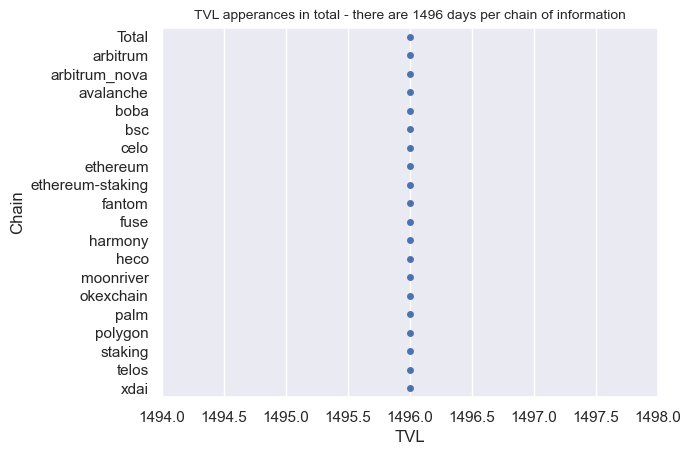

In [22]:
# TVL - if it's really what it seems, there should be one per chain per day

tvl_check = sushi.groupby('Chain', as_index = False)['Metric'].value_counts().pivot(\
index = 'Chain', columns = 'Metric', values = 'count').join(\
sushi.groupby('Chain')['Date'].nunique())

fig, ax = plt.subplots()

sns.stripplot(data = tvl_check, y = tvl_check.index, x = 'TVL', ax = ax)
ax.set_xlim(left = tvl_check.TVL.mean() - 2, right = tvl_check.TVL.mean() + 2)
ax.set_title('TVL apperances in total - there are 1496 days per chain of information', fontsize = 10)

plt.show()

In [23]:
# Now on to the Tokens & Tokens(USD) metrics
# Seems strange that total is that much superior to the rest
# It would be expected to be the sum of all chains at max if all tokens where different in each

token_metrics = sushi.loc[sushi['Date'] == '2022-12-05'].loc[~(sushi['Metric'] == 'TVL')]
token_metrics['Chain'].value_counts()

Total               11682
harmony              1846
fantom               1670
polygon              1082
bsc                   736
ethereum              554
avalanche             244
xdai                  146
arbitrum              124
moonriver              38
heco                   30
celo                   28
okexchain              26
telos                  16
fuse                   14
boba                   12
arbitrum_nova           8
ethereum-staking        4
palm                    4
staking                 4
Name: Chain, dtype: int64

In [24]:
# We can take a look at what each Metric has inside the Tokens field - there seems to be many unknowns
# There also seems to be 2 appearances - one for "Tokens" and one for "Tokens(USD)"

token_metrics.loc[token_metrics['Chain'] == 'Total']['Token'].value_counts()

USDT                                                            2
UNKNOWN (polygon:0xb2a1f431dc0a16e8d7a7edf2a418d667975da103)    2
UNKNOWN (polygon:0x6f37d76bda0682749c13c913472e4027df584820)    2
UNKNOWN (polygon:0x6a152cb7cf2e1bb246278bee122ae4d464bc173a)    2
UNKNOWN (polygon:0x5034077b88879177989558c22abf6f4253b39177)    2
                                                               ..
UNKNOWN (fantom:0xbab79c9a3a63bdadc19e82ba3a1f6ee97c480be8)     2
UNKNOWN (polygon:0x9f9808eb079544aa27f4836b42461660388c366f)    2
TIME                                                            2
UNKNOWN (fantom:0x2becb6a3a9176e5f88004c57d280f6d80a60d217)     2
1DAI                                                            2
Name: Token, Length: 5841, dtype: int64

In [25]:
# Unknowns seem to be heavility concentrated in Chain == 'Total'
token_metrics[token_metrics['Token'].str.contains('UNKNOWN')]['Chain'].value_counts()

Total        9098
harmony      1642
fantom       1476
avalanche      88
arbitrum        6
Name: Chain, dtype: int64

In [26]:
# Transform sushi DataFrame into one with unknowns all as "Unknown"
# It seems to be unknowns really that make the data set so big

sushi_t = sushi.copy()

# Fillna with False - to preserve Na values that correspond to TVL Metric

sushi_t.loc[sushi_t['Token'].str.contains('UNKNOWN').fillna(False), 'Token'] = "Unknown"

print('Token value counts')
print(sushi_t['Token'].value_counts())

# Unkown Tokens sum up 0 Value - can be grouped together as they add no information

# To fill np.nan in token field for TVL - if not groupby ignores TVL and then returns only the other two metrics

sushi_t['Token'] = sushi_t['Token'].fillna('-')

sushi_t = sushi_t.groupby((col_ids + ['Date']), as_index = False).sum()

print()
print('Value of Unknown Tokens')
print(sushi_t.loc[sushi_t['Token'] == 'Unknown']['Value'].sum())

Token value counts
Unknown    18415760
USDT          47872
USDC          44880
SUSHI         38896
WETH          38896
             ...   
ETHA           2992
ZUZ            2992
DOV            2992
KKI            2992
HODL           2992
Name: Token, Length: 1293, dtype: int64

Value of Unknown Tokens
0.0


In [27]:
sushi_t

,Protocol,Category,Chain,Metric,Token,Date,Value
0,SushiSwap,Dexes,Total,TVL,-,2018-11-03,0.00
1,SushiSwap,Dexes,Total,TVL,-,2018-11-04,0.00
2,SushiSwap,Dexes,Total,TVL,-,2018-11-05,0.00
3,SushiSwap,Dexes,Total,TVL,-,2018-11-06,0.00
4,SushiSwap,Dexes,Total,TVL,-,2018-11-07,0.00
...,...,...,...,...,...,...,...
8958043,SushiSwap,Dexes,xdai,Tokens(USD),YFI,2022-12-03,0.83
8958044,SushiSwap,Dexes,xdai,Tokens(USD),YFI,2022-12-04,0.82
8958045,SushiSwap,Dexes,xdai,Tokens(USD),YFI,2022-12-05,0.88
8958046,SushiSwap,Dexes,xdai,Tokens(USD),YFI,2022-12-06,0.87


In [28]:
# Now examine the relationship of tokens and tokens(USD)

# If they are actually the amount of tokens and that same amount in USD there should be the same amount of records

sushi_t.loc[sushi_t['Token'] == 'ETH']['Metric'].value_counts()

Tokens         13464
Tokens(USD)    13464
Name: Metric, dtype: int64

In [29]:
# Token value (usd) / token quantity should return the token price for each day

mask1 = sushi_t['Token'] == "ETH"
mask2 = sushi_t['Metric'] == "Tokens"
mask3 = sushi_t['Metric'] == "Tokens(USD)"

eth_q = sushi_t.loc[mask1 & mask2].set_index('Date').resample('D').sum()
eth_v = sushi_t.loc[mask1 & mask3].set_index('Date').resample('D').sum()
eth_px = pd.concat([eth_q, eth_v], axis = 1)
eth_px.columns = ['Quantity', 'Value']
eth_px['Price'] = eth_px['Value'].div(eth_px['Quantity'])

eth_px

,Quantity,Value,Price
Date,,,
2018-11-03,0.00,0.00,NaN
2018-11-04,0.00,0.00,NaN
2018-11-05,0.00,0.00,NaN
2018-11-06,0.00,0.00,NaN
2018-11-07,0.00,0.00,NaN
...,...,...,...
2022-12-03,216.58,279811.94,1291.93
2022-12-04,218.08,273124.71,1252.39
2022-12-05,216.69,279916.36,1291.77


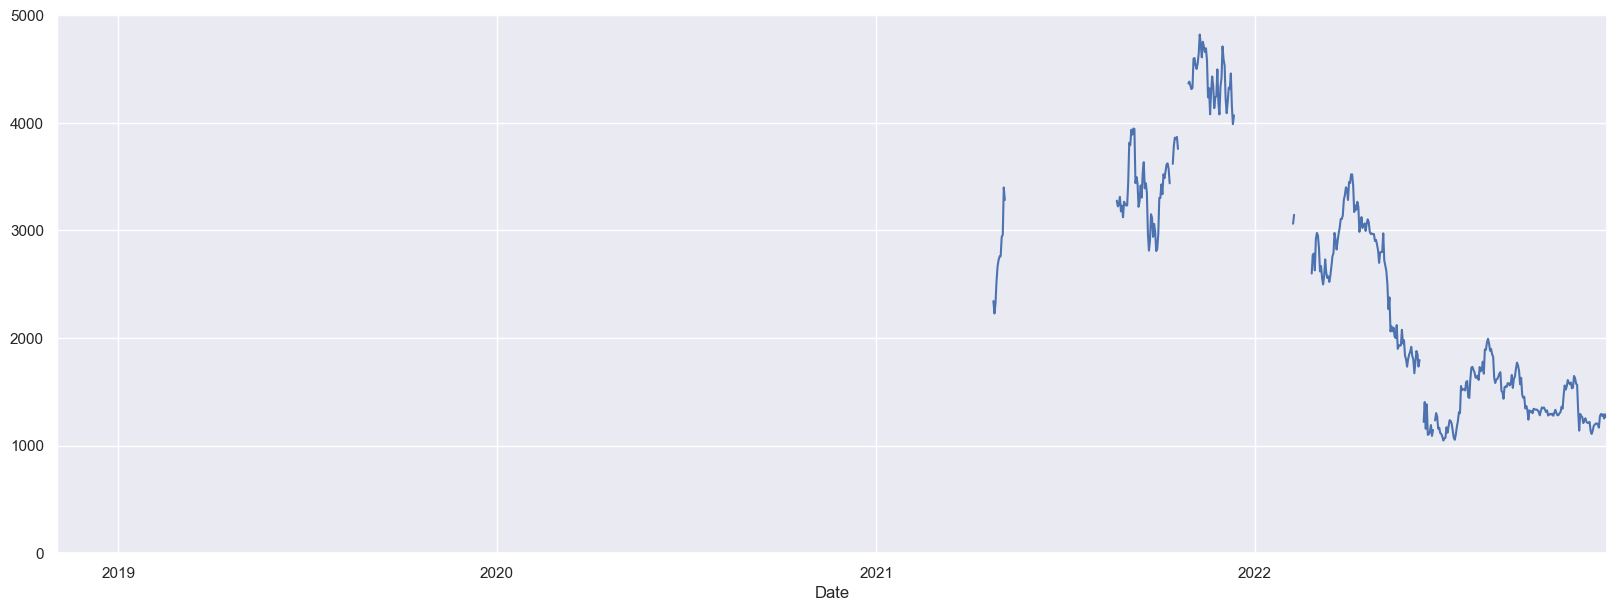

In [30]:
# Although there is missing data we have CoinGecko chart for reference - seems ok to assume we have Price

fig, ax = plt.subplots(figsize = (20,7))

eth_px['Price'].plot(  # There seems to be a lot of missing values
    kind = 'line', ax = ax
)
ax.set_ylim(bottom = 0)

plt.show()

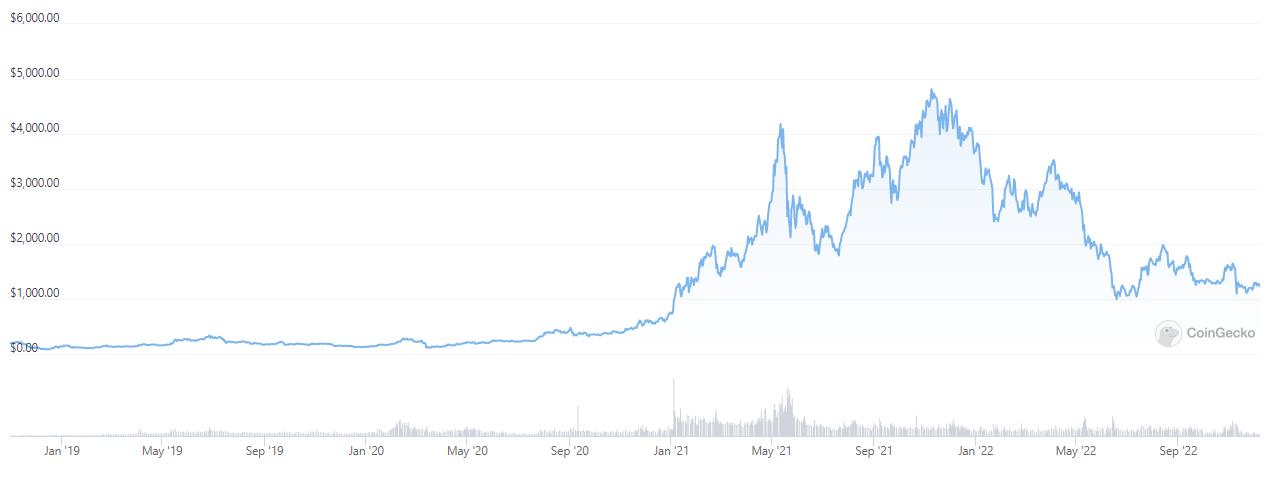

In [31]:
# A closer look into tokens - want to check distribution

sushi_tt = sushi_t.loc[sushi_t['Metric'] == 'Tokens(USD)'].copy()
sushi_tt

,Protocol,Category,Chain,Metric,Token,Date,Value
1935824,SushiSwap,Dexes,Total,Tokens(USD),$ANRX,2018-11-03,0.00
1935825,SushiSwap,Dexes,Total,Tokens(USD),$ANRX,2018-11-04,0.00
1935826,SushiSwap,Dexes,Total,Tokens(USD),$ANRX,2018-11-05,0.00
1935827,SushiSwap,Dexes,Total,Tokens(USD),$ANRX,2018-11-06,0.00
1935828,SushiSwap,Dexes,Total,Tokens(USD),$ANRX,2018-11-07,0.00
...,...,...,...,...,...,...,...
8958043,SushiSwap,Dexes,xdai,Tokens(USD),YFI,2022-12-03,0.83
8958044,SushiSwap,Dexes,xdai,Tokens(USD),YFI,2022-12-04,0.82
8958045,SushiSwap,Dexes,xdai,Tokens(USD),YFI,2022-12-05,0.88
8958046,SushiSwap,Dexes,xdai,Tokens(USD),YFI,2022-12-06,0.87


In [32]:
# USDT for Sushiswap seems to be wrong

token_value = sushi_tt.loc[sushi_tt['Chain'] == 'Total']
token_value = token_value.sort_values(by = 'Date', ascending = True)
token_value = token_value.groupby('Token', as_index = False).last()
token_value = token_value.sort_values(by = 'Value', ascending = False)
token_value

,Token,Protocol,Category,Chain,Metric,Date,Value
1139,USDT,SushiSwap,Dexes,Total,Tokens(USD),2022-12-07,353757495.68
1181,WETH,SushiSwap,Dexes,Total,Tokens(USD),2022-12-07,56691728.68
1133,USDC,SushiSwap,Dexes,Total,Tokens(USD),2022-12-07,12919593.51
1218,WXDAI,SushiSwap,Dexes,Total,Tokens(USD),2022-12-07,1128427.45
1177,WBTC,SushiSwap,Dexes,Total,Tokens(USD),2022-12-07,939557.78
...,...,...,...,...,...,...,...
470,GENE,SushiSwap,Dexes,Total,Tokens(USD),2022-12-07,0.00
469,GEIST,SushiSwap,Dexes,Total,Tokens(USD),2022-12-07,0.00
468,GDDY,SushiSwap,Dexes,Total,Tokens(USD),2022-12-07,0.00
467,GCR,SushiSwap,Dexes,Total,Tokens(USD),2022-12-07,0.00


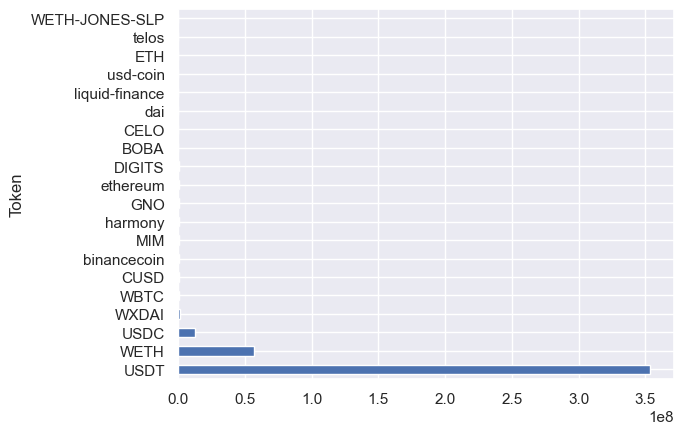

In [33]:
fig, ax = plt.subplots()

token_value.set_index('Token')['Value'].iloc[0:20].plot(
    kind = 'barh', ax = ax
)

plt.show()

In [34]:
# There seems to be a deviation in the correct amount of tokens but not with total TVL

metric = sushi_t['Metric'] == 'TVL'
chain = sushi_t['Chain'] == 'Total'

print(sushi_t.loc[metric & chain])
print(token_value['Value'].sum())

       Protocol Category  Chain Metric Token       Date        Value
0     SushiSwap    Dexes  Total    TVL     - 2018-11-03         0.00
1     SushiSwap    Dexes  Total    TVL     - 2018-11-04         0.00
2     SushiSwap    Dexes  Total    TVL     - 2018-11-05         0.00
3     SushiSwap    Dexes  Total    TVL     - 2018-11-06         0.00
4     SushiSwap    Dexes  Total    TVL     - 2018-11-07         0.00
...         ...      ...    ...    ...   ...        ...          ...
1491  SushiSwap    Dexes  Total    TVL     - 2022-12-03 419806985.19
1492  SushiSwap    Dexes  Total    TVL     - 2022-12-04 417486995.23
1493  SushiSwap    Dexes  Total    TVL     - 2022-12-05 433280415.92
1494  SushiSwap    Dexes  Total    TVL     - 2022-12-06 430008688.47
1495  SushiSwap    Dexes  Total    TVL     - 2022-12-07 431055415.49

[1496 rows x 7 columns]
431055415.4868965


___

So where are we standing now in reference to our data fields?

## all.csv Data Fields - complete

- Protocol (str): DefiLlama name of the protocol
- Category (str): DefiLlama category of the protocol
- Chain (str): Chain to which the TVL calculated corresponds
    - name of a blockchain
    - Total - sum of all individual blockchains
- Metric (str)
    - TVL: the metric we all know
        - Doesn't have many tokens, just and identifier for the lack of token - for the aggregate
    - Tokens: token amount
    - Tokens(USD): token value in USD
- Token (str)
    - Token ticker - there are unknowns and and Identifier where token doesn't apply
    - Token = 'tether' - placeholder for unknowns or not tracked
- Value (float): Value depending on the combination of the 5 fields above
___

## Double-checking TVL metrics with csv from DefiLlama frontend
___

It seems that total TVL is correct although for SushiSwap which was the example taken, USDT is calculated in excess

In [35]:
token_value.set_index('Token')[token_value.set_index('Token').index.str.lower().str.contains('dai')]

,Protocol,Category,Chain,Metric,Date,Value
Token,,,,,,
WXDAI,SushiSwap,Dexes,Total,Tokens(USD),2022-12-07,1128427.45
dai,SushiSwap,Dexes,Total,Tokens(USD),2022-12-07,181870.04
DAI,SushiSwap,Dexes,Total,Tokens(USD),2022-12-07,79.97
YDAI+YUSDC+YUSDT+YTUSD,SushiSwap,Dexes,Total,Tokens(USD),2022-12-07,0.76
CDAI,SushiSwap,Dexes,Total,Tokens(USD),2022-12-07,0.00
AMDAI,SushiSwap,Dexes,Total,Tokens(USD),2022-12-07,0.00
1DAI-BUSD-SLP,SushiSwap,Dexes,Total,Tokens(USD),2022-12-07,0.00
1DAI,SushiSwap,Dexes,Total,Tokens(USD),2022-12-07,0.00
MADAI,SushiSwap,Dexes,Total,Tokens(USD),2022-12-07,0.00


In [36]:
ui_source = pd.read_csv('chain-dataset-All.csv')
ui_source

,Protocol,03/11/2018,04/11/2018,05/11/2018,06/11/2018,07/11/2018,08/11/2018,09/11/2018,10/11/2018,11/11/2018,...,05/12/2022,06/12/2022,07/12/2022,08/12/2022,09/12/2022,10/12/2022,11/12/2022,12/12/2022,13/12/2022,14/12/2022
0,Total,34643.89,41268.18,40551.78,43091.34,153979.39,180229.00,175773.26,172207.68,187642.44,...,42629247711.11,42149222455.70,42233856339.68,42115887044.01,42202552669.31,42141499374.78,42311845595.95,41718348529.64,41836099961.13,42127491439.16
1,Uniswap V1,34643.89,41268.18,40551.78,43091.34,153979.39,180229.00,175773.26,172207.68,187642.44,...,7922435.74,7987430.73,7929468.97,7639315.96,7766176.15,7668793.35,7702293.72,7703099.57,7683501.89,7756622.73
2,MakerDAO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6719128397.65,6579498052.58,6346262213.10,6262692706.28,6332687575.15,6303424369.22,6317701067.41,6284051605.16,6306539163.34,6424936370.44
3,Compound,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1509488597.92,1477989045.46,1485614949.61,1464795953.28,1488655777.02,1490625424.41,1499765428.00,1469755175.37,1475557416.33,1495420635.18
4,Nexus Mutual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,177336516.91,173677009.62,174131655.10,169478542.56,175140197.77,173559898.07,174083789.18,172582265.51,174633470.85,181637764.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406,Gamut Exchange,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008.62,2007.25,2016.09
1407,El Dorado Exchange,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,361010.21,344552.82,376560.52
1408,Roe Finance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,878618.74,885703.54,898157.84
1409,Dexit Finance Swap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91076.70


In [44]:
ui_source.columns

Index(['Protocol', '03/11/2018', '04/11/2018', '05/11/2018', '06/11/2018',
       '07/11/2018', '08/11/2018', '09/11/2018', '10/11/2018', '11/11/2018',
       ...
       '05/12/2022', '06/12/2022', '07/12/2022', '08/12/2022', '09/12/2022',
       '10/12/2022', '11/12/2022', '12/12/2022', '13/12/2022', '14/12/2022'],
      dtype='object', length=1504)

In [47]:
# For this to run smoothly, it is assumed that chain-dataset-all.csv will be always more updated than all.csv
ui_df = ui_source.iloc[1:].loc[:, ['Protocol', pd.to_datetime(all_up_date).strftime('%d/%m/%Y')]].set_index('Protocol')
ui_df.columns = ['tvl']
ui_df

,tvl
Protocol,
Uniswap V1,7929468.97
MakerDAO,6346262213.10
Compound,1485614949.61
Nexus Mutual,174131655.10
Synthetix,317964121.94
...,...
Gamut Exchange,NaN
El Dorado Exchange,NaN
Roe Finance,NaN


In [52]:
chain_mask = source_['Chain'] == 'Total'
metric_mask = source_['Metric'] == 'TVL'

source_df = source_.loc[chain_mask & metric_mask].iloc[:, [0, -1]]\
.set_index('Protocol')

source_df.columns = ['tvl']
source_df

,tvl
Protocol,
WBTC,3407707662.7911773
Harvest Finance,15713520.101983376
Yearn Finance,377551591.7578955
Synthetix,317964121.94206274
Hegic,5977174.5098917615
...,...
Defi Kingdoms,2560470.480389393
Uniswap V3,2564024885.920934
ViperSwap,120627.96231863814


In [53]:
tvl = source_df.join(ui_df, on = None, how = 'left', lsuffix = '_source', rsuffix = '_ui')
tvl = tvl.astype(float)
tvl

,tvl_source,tvl_ui
Protocol,,
WBTC,3407707662.79,NaN
Harvest Finance,15713520.10,NaN
Yearn Finance,377551591.76,NaN
Synthetix,317964121.94,317964121.94
Hegic,5977174.51,5977174.51
...,...,...
Defi Kingdoms,2560470.48,2560470.48
Uniswap V3,2564024885.92,2564024885.92
ViperSwap,120627.96,120627.96


In [54]:
tvl['rel'] = tvl['tvl_source'].div(tvl['tvl_ui'])
tvl

,tvl_source,tvl_ui,rel
Protocol,,,
WBTC,3407707662.79,NaN,NaN
Harvest Finance,15713520.10,NaN,NaN
Yearn Finance,377551591.76,NaN,NaN
Synthetix,317964121.94,317964121.94,1.00
Hegic,5977174.51,5977174.51,1.00
...,...,...,...
Defi Kingdoms,2560470.48,2560470.48,1.00
Uniswap V3,2564024885.92,2564024885.92,1.00
ViperSwap,120627.96,120627.96,1.00


In [66]:
tvl['rel'].value_counts()

1.00    1090
1.00      89
1.00      76
1.00      28
1.00       2
0.52       1
1.00       1
1.00       1
1.00       1
1.00       1
1.00       1
1.00       1
Name: rel, dtype: int64

# 2. Data Transformation
___
Transform data in order to get everything in one table.

Generate one table for DAI stablecoin, in order to get its locations within blockchain space.

Only Ethereum blockchain will be considered because of the % of DAI present in it

Schema:
1. date (datetime)
2. protocol (str): name of the protocol
    - Can be a defi protocol or the name of an exchange, a bot, etc
3. category (str): defillama category, CeFi, MEV, CEX, ...
4. location (str): defi, cefi, free, burned
5. value (float): value of DAI for that record

- Where is DAI located, understanding flows from its sources to its destinations

In [68]:
# First get circulating DAI in chains

circ_dai = research_utils.llama_hist_circulating_stables(5)  # using user-defined module
circ_dai

,date,circulating,minted,bridged_to,chain
0,2022-05-12,17758618.29,0.00,17758618.29,Optimism
1,2022-05-13,17166365.62,0.00,17166365.62,Optimism
2,2022-05-14,17166378.42,0.00,17166378.42,Optimism
3,2022-05-15,17183182.51,0.00,17183182.51,Optimism
4,2022-05-16,17194908.70,0.00,17194908.70,Optimism
...,...,...,...,...,...
108,2022-12-10,197590.95,0.00,197590.95,Everscale
109,2022-12-11,197590.95,0.00,197590.95,Everscale
110,2022-12-12,197590.95,0.00,197590.95,Everscale
111,2022-12-13,197590.95,0.00,197590.95,Everscale


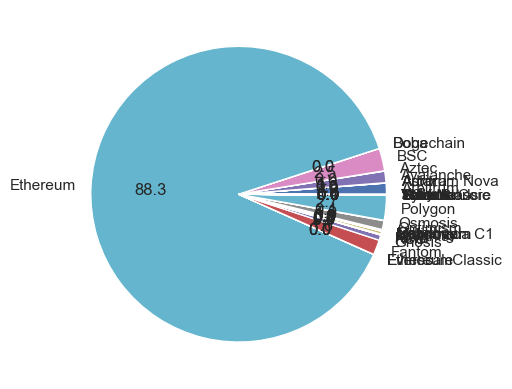

In [69]:
fig,ax = plt.subplots()


circ_dai.sort_values(by = 'date', ascending = True).groupby('chain').last()['circulating'].plot(
    kind = 'pie', ax = ax, autopct = "%.1f"
)
ax.set_ylabel("")

plt.show()

In [70]:
# Dimensionality reduction with "Unknown" tokens aggregation

source__ = source_.copy()
source__.loc[source__['Token'].str.contains('UNKNOWN').fillna(False), 'Token'] = "Unknown"
source__

,Protocol,Category,Chain,Metric,Token,2018-11-03 00:00:00,2018-11-04 00:00:00,2018-11-05 00:00:00,2018-11-06 00:00:00,2018-11-07 00:00:00,...,2022-11-28 00:00:00,2022-11-29 00:00:00,2022-11-30 00:00:00,2022-12-01 00:00:00,2022-12-02 00:00:00,2022-12-03 00:00:00,2022-12-04 00:00:00,2022-12-05 00:00:00,2022-12-06 00:00:00,2022-12-07 00:00:00
2,WBTC,Bridge,ethereum,TVL,NaN,NaN,NaN,NaN,NaN,NaN,...,3584683604.588976,3505677587.457509,3633312927.5250263,3695193538.1129208,3655991803.249629,3574076715.9392896,3549157011.2662163,3611187415.717093,3576731681.1033792,3407707662.7911773
3,WBTC,Bridge,Total,TVL,NaN,NaN,NaN,NaN,NaN,NaN,...,3584683604.588976,3505677587.457509,3633312927.5250263,3695193538.1129208,3655991803.249629,3574076715.9392896,3549157011.2662163,3611187415.717093,3576731681.1033792,3407707662.7911773
4,WBTC,Bridge,ethereum,Tokens(USD),WBTC,NaN,NaN,NaN,NaN,NaN,...,3584683604.588976,3505677587.457509,3633312927.5250263,3695193538.1129208,3655991803.249629,3574076715.9392896,3549157011.2662163,3611187415.717093,3576731681.1033792,3407707662.7911773
5,WBTC,Bridge,Total,Tokens(USD),WBTC,NaN,NaN,NaN,NaN,NaN,...,3584683604.588976,3505677587.457509,3633312927.5250263,3695193538.1129208,3655991803.249629,3574076715.9392896,3549157011.2662163,3611187415.717093,3576731681.1033792,3407707662.7911773
6,WBTC,Bridge,ethereum,Tokens,WBTC,NaN,NaN,NaN,NaN,NaN,...,218226.97636664,216975.3715539,215871.1923539,214745.1923489,214745.1923489,210044.7123489,210044.7123489,210044.7123489,210044.7123489,200044.7123489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263814,SushiSwap,Dexes,avalanche,Tokens,SIFU,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263815,SushiSwap,Dexes,avalanche,Tokens,VERS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263816,SushiSwap,Dexes,avalanche,Tokens,MIM3CRV-F,NaN,NaN,NaN,NaN,NaN,...,7e-18,7e-18,7e-18,7e-18,7e-18,7e-18,7e-18,7e-18,7e-18,7e-18
263817,SushiSwap,Dexes,avalanche,Tokens,AXEN,NaN,NaN,NaN,NaN,NaN,...,14765484.469782973,14765484.469782973,14765484.469782973,14765484.469782973,14765484.469782973,14765484.469782973,14765484.469782973,14765484.469782973,14765484.469782973,14765484.469782973


In [77]:
# Dimensionality reduction - by using DAI
# DAI may appear in different string formats

chain_mask = source__['Chain'] == 'ethereum'
metric_mask = source__['Metric'] == 'Tokens(USD)'
token_mask = source__['Token'].str.lower().str.contains('dai')

dai_defi = source__.loc[chain_mask & metric_mask & token_mask]
dai_defi = dai_defi.melt(id_vars = col_ids, value_vars = dai_defi.columns[5:], var_name = 'Date', value_name = 'Value')
dai_defi.columns = dai_defi.columns.str.lower()
dai_defi = dai_defi[['date', 'protocol', 'category', 'token', 'value']]
dai_defi

,date,protocol,category,token,value
0,2018-11-03,Loopring,Dexes,DAI,NaN
1,2018-11-03,BarnBridge,Yield Aggregator,DAI,NaN
2,2018-11-03,MakerDAO,CDP,ADAI,NaN
3,2018-11-03,MakerDAO,CDP,DAI,NaN
4,2018-11-03,MakerDAO,CDP,DAI-WBTC-UNI-V2,NaN
...,...,...,...,...,...
523595,2022-12-07,Uniswap V3,Dexes,YF-DAI,NaN
523596,2022-12-07,Uniswap V3,Dexes,ADAI,NaN
523597,2022-12-07,Uniswap V3,Dexes,CDAI,110674.02797375494
523598,2022-12-07,SushiSwap,Dexes,CDAI,NaN


In [78]:
dai_defi = dai_defi.astype({'value': float})
dai_defi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523600 entries, 0 to 523599
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      523600 non-null  datetime64[ns]
 1   protocol  523600 non-null  object        
 2   category  523600 non-null  object        
 3   token     523600 non-null  object        
 4   value     79318 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 20.0+ MB


In [79]:
# Check DAI tokens that are included in dai_defi - there seems to be things like cDAI included
# The only two that will be taken into account are ['DAI', 'dai']
# The others seem to be a double count if included, as they are essentially wrapped DAI or DAI deposited in vaults

dai_defi.loc[dai_defi['date'] == '2022-12-07'].groupby('token').sum().sort_values(by = 'value', ascending = False)

,value
token,
DAI,1413939340.07
CDAI+CUSDC,40783645.11
CDAI,21841003.91
YDAI+YUSDC+YUSDT+YTUSD,3977947.26
YVDAI,673724.73
dai,522183.74
YDAI+YUSDC+YUSDT+YBUSD,303293.80
ADAI,197406.73
YYDAI+YUSDC+YUSDT+YTUSD,161300.57


In [82]:
mask1 = dai_defi['token'] == 'DAI'
mask2 = dai_defi['token'] == 'dai'

dai_defi.loc[mask1 | mask2, 'token'] = 'DAI'
dai_defi.loc[mask1 | mask2]

,date,protocol,category,token,value
0,2018-11-03,Loopring,Dexes,DAI,NaN
1,2018-11-03,BarnBridge,Yield Aggregator,DAI,NaN
3,2018-11-03,MakerDAO,CDP,DAI,NaN
7,2018-11-03,Nexus Mutual,Insurance,DAI,NaN
8,2018-11-03,mStable,CDP,DAI,NaN
...,...,...,...,...,...
523573,2022-12-07,xDAI Stake Bridge,Chain,DAI,33276932.12
523587,2022-12-07,Set Protocol,Indexes,DAI,1601841.98
523593,2022-12-07,Nested,Services,DAI,627.32
523594,2022-12-07,Uniswap V3,Dexes,DAI,291054893.69


## Checkpoint

We now have:
1. Location of all DAI in ethereum locked in DeFi protocols included in DefiLlama
2. Circulating DAI in Ethereum and other chains

We need DAI in known addresses, which are included in ethereumTags.csv

Once we can determine the amount of DAI in those addresses we can estimate where DAI is according to the attributes defined for the final circulating DAI Table 

In [83]:
ethereum_tags = pd.read_csv('ethereum_tags.csv')
ethereum_tags['address'] = ethereum_tags['address'].str.lower()
ethereum_tags = ethereum_tags.set_index('address').drop('rank', axis = 1)
ethereum_tags

,etherscan_tag,protocol,category,location
address,,,,
0xf977814e90da44bfa03b6295a0616a897441acec,Binance 8,Binance,cex,cefi
0xbe0eb53f46cd790cd13851d5eff43d12404d33e8,Binance 7,Binance,cex,cefi
0x28c6c06298d514db089934071355e5743bf21d60,Binance 14,Binance,cex,cefi
0x34ea4138580435b5a521e460035edb19df1938c1,Binance US 2,Binance,cex,cefi
0x4976a4a02f38326660d17bf34b431dc6e2eb2327,Binance 20,Binance,cex,cefi
...,...,...,...,...
0xf71530c1f043703085b42608ff9dcccc43210a8e,MEV Bot: 0xF71...a8E,Bot,MEV,free
0xf7c517e7e545d8f3286d336372b65995b81b91c2,MEV Bot: 0xf7c...1c2,Bot,MEV,free
0xfbf6b914a5c1355db7a6aa63df81f24aca987358,MEV Bot: 0xFbf...358,Bot,MEV,free


In [113]:
# Etherscan API request to get DAI holdings of addresses in ethereum_tags DataFrame

data_list = []
q = 1

for address in ethereum_tags.index:
    url = 'https://api.etherscan.io/api'

    res = requests.get(
        url,
        params = {
            'module': 'account',
            'action': 'tokenbalance',
            'contractaddress': '0x6B175474E89094C44Da98b954EedeAC495271d0F',
            'address': address,
            'tag': 'latest',
            'apiKey': 'APIKEY'  # This should have personal API key inside
        }
    )
    
    if q % 50 == 0:
        print(q)
    q += 1
    
    time.sleep(0.25)
    data_list.append([address, float(res.json()['result']) / 10**18])

50
100
150
200
250
300
350
400
450
500
550
600


In [121]:
dai_holdings = pd.DataFrame(data_list)
dai_holdings.columns = ['owner', 'value']
dai_holdings['date'] = pd.to_datetime(datetime.now().strftime('%y-%m-%d'))
dai_holdings.to_csv('dai_holdings.csv')
dai_holdings

,owner,value,date
0,0xf977814e90da44bfa03b6295a0616a897441acec,100000000.00,2014-12-22
1,0xbe0eb53f46cd790cd13851d5eff43d12404d33e8,0.00,2014-12-22
2,0x28c6c06298d514db089934071355e5743bf21d60,24428662.17,2014-12-22
3,0x34ea4138580435b5a521e460035edb19df1938c1,184435.44,2014-12-22
4,0x4976a4a02f38326660d17bf34b431dc6e2eb2327,0.00,2014-12-22
...,...,...,...
640,0xf71530c1f043703085b42608ff9dcccc43210a8e,0.00,2014-12-22
641,0xf7c517e7e545d8f3286d336372b65995b81b91c2,0.00,2014-12-22
642,0xfbf6b914a5c1355db7a6aa63df81f24aca987358,0.00,2014-12-22
643,0xff2fbc735d33ae830f056107f1b551783ec4ed5b,0.00,2014-12-22


In [123]:
# Join dai_holdings with ethereum_tags to get attributes of possible known addresses holding DAI

dai_locs = pd.concat([dai_holdings.join(ethereum_tags, on = 'owner', how = 'left').dropna(),\
                      dai_defi.loc[mask1 | mask2]], axis = 0)
dai_locs = dai_locs[['date', 'protocol', 'category', 'location', 'value']]
dai_locs

,date,protocol,category,location,value
0,2014-12-22,Binance,cex,cefi,100000000.00
1,2014-12-22,Binance,cex,cefi,0.00
2,2014-12-22,Binance,cex,cefi,24428662.17
3,2014-12-22,Binance,cex,cefi,184435.44
4,2014-12-22,Binance,cex,cefi,0.00
...,...,...,...,...,...
523573,2022-12-07,xDAI Stake Bridge,Chain,NaN,33276932.12
523587,2022-12-07,Set Protocol,Indexes,NaN,1601841.98
523593,2022-12-07,Nested,Services,NaN,627.32
523594,2022-12-07,Uniswap V3,Dexes,NaN,291054893.69


In [124]:
dai_locs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356695 entries, 0 to 523599
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      356695 non-null  datetime64[ns]
 1   protocol  356695 non-null  object        
 2   category  356695 non-null  object        
 3   location  647 non-null     object        
 4   value     65516 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 16.3+ MB


In [125]:
dai_locs['location'] = dai_locs['location'].fillna('defi')

In [126]:
# Consolidation of protocols that repeat themselves

dai_locs = dai_locs.groupby(['date', 'protocol', 'category', 'location'], as_index = False).sum()
dai_locs

,date,protocol,category,location,value
0,2014-12-22,API3,treasury,free,0.00
1,2014-12-22,Aavegotchi,treasury,free,19567669.11
2,2014-12-22,Aragon,treasury,free,20031219.75
3,2014-12-22,AscendEX,cex,cefi,0.00
4,2014-12-22,BLockFi,CeFi,cefi,0.00
...,...,...,...,...,...
354605,2022-12-07,deBridge,Bridge,defi,17.29
354606,2022-12-07,mStable,CDP,defi,3492530.64
354607,2022-12-07,unFederalReserve,Lending,defi,92064.70
354608,2022-12-07,xDAI Stake Bridge,Chain,defi,33276932.12


In [127]:
# So in order to run get the desired snapshot of DAI holdings up to the last date possible...
# We'll have to assume that defi-locked DAI on 22/12/07 is equivalent to 22/12/14
# DAI holdings for addresses in ethereum_tags is only calculated for 22/12/14

# IF snapshot_date and dai_defi_last_date are both the same date, the one of the two subtractions below should be deleted

snapshot_date = '2022-12-14'

if snapshot_date != all_up_date:
    piece = dai_locs.loc[dai_locs['date'] == all_up_date]
    piece['date'] = pd.to_datetime(snapshot_date, format = "%Y/%m/%d")
    dai_locs_f = pd.concat([dai_locs, piece], axis = 0, ignore_index = True)
else:
    dai_locs_f = dai_locs.copy()
    
dai_locs_f.loc[len(dai_locs_f) + 1, :] = [dai_locs_f.iloc[-1, 0], '-', '-', 'circulating',
                            circ_dai.loc[(circ_dai['date'] == snapshot_date) & \
                                         (circ_dai['chain'] == 'Ethereum')]['circulating'] \
                           - dai_locs_f.loc[dai_locs_f['date'] == snapshot_date]['value'].sum()]

C:\Users\tomas\AppData\Local\Temp\ipykernel_11744\3285905284.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  piece['date'] = pd.to_datetime(snapshot_date, format = "%Y/%m/%d")
C:\Users\tomas\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


In [129]:
dai_locs_f.to_csv('dai_locs.csv')
dai_locs_f

,date,protocol,category,location,value
0,2014-12-22,API3,treasury,free,0.00
1,2014-12-22,Aavegotchi,treasury,free,19567669.11
2,2014-12-22,Aragon,treasury,free,20031219.75
3,2014-12-22,AscendEX,cex,cefi,0.00
4,2014-12-22,BLockFi,CeFi,cefi,0.00
...,...,...,...,...,...
354843,2022-12-14,mStable,CDP,defi,3492530.64
354844,2022-12-14,unFederalReserve,Lending,defi,92064.70
354845,2022-12-14,xDAI Stake Bridge,Chain,defi,33276932.12
354846,2022-12-14,xSigma,Dexes,defi,119640.81


An assumption has to be taken on the topic if bridges contain DAI in other chains as TVL
There are different kinds of bridges - the ones that mint synthetics and the ones that mint real assets
There may be a difference among both

Im assuming that between cross-chain TVL and bridge TVL, we can find dai that has been bridged to other chains